
This notebook explores serve performance in ATP men's singles tennis from 2010 to 2024. It analyzes how serving metrics evolve across tournament rounds, surfaces, and player characteristics using fixed effects regression and PCA.

The project addresses the question: "Is it the match or is it the moment?" by investigating how much of a player's serve performance is determined by factors such as surface, opponent, and round difficulty.

Data source: ATP Tour match-level statistics (2010–2024), cleaned and processed.

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

# Loading and merging refined yearly ATP data
years = list(range(2010, 2024))
dfs = []
for year in years:
    file_path = f'data/atp_matches_{year}.csv'
    df = pd.read_csv(file_path)
    df['year'] = year
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# cleaning column names and dropping missing values
df_all.columns = [col.strip().lower().replace(' ', '_') for col in df_all.columns]
df_all = df_all.dropna(subset=['w_ace','w_df','w_svpt', 'w_1stin', 'w_1stwon', 'w_2ndwon', 'w_svgms','w_bpsaved','w_bpfaced', 'l_ace','l_df', 'l_svpt','l_1stin', 'l_1stwon', 'l_2ndwon', 'l_svgms','l_bpsaved','l_bpfaced', 'winner_ioc', 'loser_ioc', 'tourney_name'])

# dropping incomplete rows
df_all = df_all.dropna(subset=['w_ace','w_df','w_svpt', 'w_1stin', 'w_1stwon', 'w_2ndwon', 'w_svgms','w_bpsaved','w_bpfaced', 'l_ace','l_df', 'l_svpt','l_1stin', 'l_1stwon', 'l_2ndwon', 'l_svgms','l_bpsaved','l_bpfaced', 'winner_ioc', 'loser_ioc', 'tourney_name'])

# Mapping tournament names to host countries
tourney_to_country = {
    'Brisbane': 'AUS', 'Chennai': 'IND', 'Doha': 'QAT', 'Auckland': 'NZL',
    'Sydney': 'AUS', 'Australian Open': 'AUS', 'Johannesburg': 'RSA',
    'Santiago': 'CHI', 'Zagreb': 'CRO', 'Costa Do Sauipe': 'BRA',
    'Rotterdam': 'NED', 'San Jose': 'USA', 'Buenos Aires': 'ARG',
    'Marseille': 'FRA', 'Memphis': 'USA', 'Acapulco': 'MEX',
    'Delray Beach': 'USA', 'Dubai': 'UAE', 'Indian Wells Masters': 'USA',
    'Miami Masters': 'USA', 'Casablanca': 'MAR', 'Houston': 'USA',
    'Monte Carlo Masters': 'MCO', 'Barcelona': 'ESP', 'Rome Masters': 'ITA',
    'Munich': 'GER', 'Belgrade': 'SRB', 'Estoril': 'POR',
    'Madrid Masters': 'ESP', 'Dusseldorf': 'GER', 'Nice': 'FRA',
    'Roland Garros': 'FRA', 'Halle': 'GER', "Queen's Club": 'GBR',
    'Eastbourne': 'GBR', "s Hertogenbosch": 'NED', 'Wimbledon': 'GBR',
    'Newport': 'USA', 'Atlanta': 'USA', 'Hamburg': 'GER', 'Gstaad': 'SUI',
    'Los Angeles': 'USA', 'Umag': 'CRO', 'Washington': 'USA',
    'Canada Masters': 'CAN', 'Cincinnati Masters': 'USA', 'New Haven': 'USA',
    'US Open': 'USA', 'Bucharest': 'ROU', 'Metz': 'FRA', 'Bangkok': 'THA',
    'Kuala Lumpur': 'MAS', 'Beijing': 'CHN', 'Tokyo': 'JPN',
    'Shanghai Masters': 'CHN', 'Moscow': 'RUS', 'Stockholm': 'SWE',
    'Montpelier': 'FRA', 'St. Petersburg': 'RUS', 'Vienna': 'AUT',
    'Valencia': 'ESP', 'Basel': 'SUI', 'Paris Masters': 'FRA', 'Tour Finals': 'GBR',
}

# combining all "bad" tournaments into a single regex pattern & filtering them out
pattern = 'Davis Cup|Laver Cup|Tokyo Olympics|Dusseldorf'
df_all = df_all[~df_all['tourney_name'].str.contains(pattern, case=False, na=False)]

# standardizes spacing
df_all['tourney_name'] = df_all['tourney_name'].str.strip()

# creating home dummy var
df_all['tourney_name'] = df_all['tourney_name'].str.strip()
df_all['tourney_country'] = df_all['tourney_name'].map(tourney_to_country)

# home dummy for winner
df_all['winner_home'] = (df_all['winner_ioc'] == df_all['tourney_country']).astype(int)
# home dummy for loser (if needed)
df_all['loser_home'] = (df_all['loser_ioc'] == df_all['tourney_country']).astype(int)


# saving clean data
df_all.to_csv('data/atp_matches_cleaned.csv', index=False)

# mapping round number
round_order = {'R128':1, 'R64':2,'R32':3,'R16':4,'QF':5,'SF':6,'F':7}
df_all['round_num'] = df_all['round'].map(round_order)


# winner dataframe
winner_df = df_all[['tourney_id','tourney_name','tourney_level', 'tourney_country', 'surface', 'year',
                    'winner_name', 'winner_ioc',
                    'w_ace', 'w_df', 'w_svpt', 'w_1stin', 'w_1stwon', 'w_2ndwon',
                    'w_svgms', 'w_bpsaved', 'w_bpfaced']].copy()

winner_df['home'] = (winner_df['winner_ioc'] == winner_df['tourney_country'])
winner_df.columns = ['tourney_id','tourney_name','tourney_level', 'tourney_country', 'surface', 'year', 'player_name', 'player_ioc', 'aces', 'double_faults', 'svpt',
                     'first_in', 'first_won', 'second_won', 'service_games',
                     'break_points_saved', 'break_points_faced', 'home']

# loser dataframe
loser_df = df_all[['tourney_id', 'tourney_name','tourney_level', 'tourney_country', 'surface', 'year', 'loser_name','loser_ioc', 'l_ace','l_df', 'l_svpt','l_1stin', 'l_1stwon', 'l_2ndwon', 'l_svgms','l_bpsaved','l_bpfaced']].copy()
loser_df['home'] = (loser_df['loser_ioc'] == loser_df['tourney_country'])
loser_df.columns = ['tourney_id', 'tourney_name', 'tourney_level', 'tourney_country', 'surface', 'year',
                    'player_name', 'player_ioc', 'aces', 'double_faults', 'svpt',
                    'first_in', 'first_won', 'second_won', 'service_games',
                    'break_points_saved', 'break_points_faced', 'home']

frames = [winner_df, loser_df]
player_df = pd.concat(frames, ignore_index=True)
player_df.columns = [col.strip().lower().replace(' ', '_') for col in player_df.columns]
# dropping matches with 0 or missing serve games
player_df = player_df[player_df['service_games'] > 0]

# grouping tournaments with the same length
player_df = player_df.merge(df_all[['tourney_id', 'round', 'round_num']], on='tourney_id', how='left')

# first serve percentage metric
player_df['first_serve_pct'] = player_df['first_in'] / player_df['svpt']

# second serve percentage metric
player_df['second_serve_pct'] = (
    (player_df['svpt'] - player_df['first_in'] - player_df['double_faults']) /
    (player_df['svpt'] - player_df['first_in'])
)


# player/tourney id tracking
player_df['player_tourney_id'] = player_df['player_name'] + '_' + player_df['tourney_id']

player_df = player_df.dropna(subset=['first_serve_pct', 'round_num'])
grouped = player_df.groupby(['player_tourney_id', 'round_num']).agg({'first_serve_pct': 'mean'}).reset_index()

# grouping
grouped = player_df.groupby(['player_tourney_id', 'round_num']).agg({'first_serve_pct': 'mean'}). reset_index()


Pooled OLS Model was used initially, but findings concluded it doesn't do well at explaining variation in serve performance.

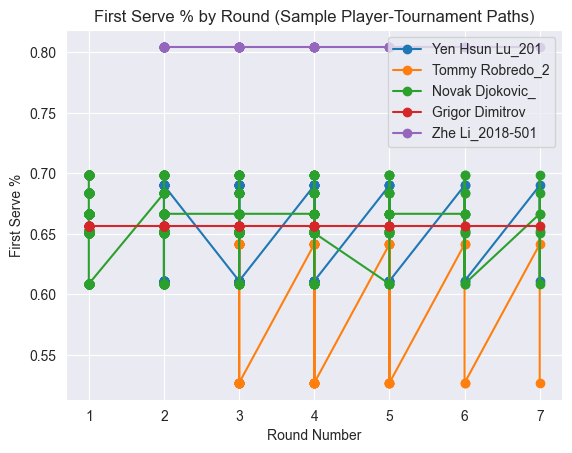

Intercept: 0.614749072602903
Coefficients: -0.00034158331655912794
R-squared: 4.313656988597092e-05


In [2]:
# cleaning
player_df = player_df.dropna(subset = ['first_in', 'svpt'])
player_df = player_df[player_df['svpt'] > 0]

sample_ids = grouped['player_tourney_id'].drop_duplicates().sample(5,random_state=1)

for ptid in sample_ids:
    temp = player_df[player_df['player_tourney_id']==ptid].sort_values('round_num')
    plt.plot(temp['round_num'], temp['first_serve_pct'], marker = 'o', label=ptid[:15])
plt.xlabel('Round Number')
plt.ylabel('First Serve %')
plt.title('First Serve % by Round (Sample Player-Tournament Paths)')
plt.legend()
plt.show()

df_model = player_df.dropna(subset = ['first_serve_pct', 'round_num'])
X = df_model[['round_num']]
y = df_model['first_serve_pct']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_[0])
print("R-squared:", r2_score(y, y_pred))

player_df['first_in'] = player_df['first_in'].astype(float)
player_df['svpt'] = player_df['svpt'].astype(float)

On average, first serve pct for an ATP player is 61.5%. On average, first serve pct for an ATP player goes down by .0003% after each round. The Pooled Ols Model gives a very low R-squared value, indicating it is not good at explaining almost any of the variation in first serve percentages.

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# polynomial features (degree 2 = quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_model[['round_num']])

# fitting model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)

# results

print("Intercept:", round(float(poly_model.intercept_), 4))
coeffs = {
    name: round(float(value), 4)
    for name, value in zip(poly.get_feature_names_out(['round_num']), poly_model.coef_)
}
print("Coefficients:", coeffs)

print("R-squared (Polynomial):", round(r2_score(y, y_pred_poly), 4))


Intercept: 0.6165
Coefficients: {'round_num': -0.0018, 'round_num^2': 0.0002}
R-squared (Polynomial): 0.0001


Another test of the Pooled OLS Model giving similar results as above.
The lack of explanation in the variance of first serve percentage is most likely due to the fact that ATP players are quite consistent across the board; so a pooled model will negate individual player characteristics, essentially treating all players the same. This is a large concern because characteristics such as height, age, or play-style play a significant role is a players serving capabilities. A player like Reilly Opelka standing at 6'11" will serve vastly different from a player like Diego Schwartzman standing at 5'7", for example. This can lead to omitted variable bias which will make it difficult to tell if differences in performance can be attributed to factors such as round number and surface type or an omitted variable like player height. Therefore, a transition to a fixed effects model is ideal because it controls for everything unique about a player that doesn't change across matches. Each player is assigned its own dummy variable-omitting one to avoid perfect multicollinearity.

In [4]:
# cleaning
fe_df = player_df.dropna(subset=['first_serve_pct', 'round_num', 'player_name'])

# Top 25 players
top_players = fe_df['player_name'].value_counts().head(25).index
fe_sample = fe_df[fe_df['player_name'].isin(top_players)]

# sample max: 1000 total observations (too large to run)
fe_sample = fe_sample.sample(1000, random_state=1)

# fixed effects regression
model_fe = smf.ols('first_serve_pct ~ round_num + C(player_name)', data=fe_sample).fit()
print(model_fe.summary())

# option setting to make outputs more readable
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)


                            OLS Regression Results                            
Dep. Variable:        first_serve_pct   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     8.948
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           5.91e-30
Time:                        08:27:59   Log-Likelihood:                 1269.1
No. Observations:                1000   AIC:                            -2486.
Df Residuals:                     974   BIC:                            -2359.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

On average, the first serve % of an atp player is 61.4%, holding all else constant. About 18.7% of variation in serve % is explained by round number and who the player is.

In [5]:
# baseline pooled OLS model
model_pooled = smf.ols('first_serve_pct ~ round_num', data=fe_sample).fit()

# fixed effects model with player dummies
model_fe = smf.ols('first_serve_pct ~ round_num + C(player_name)', data=fe_sample).fit()

# F-test
f_stat, p_value, df_diff = model_fe.compare_f_test(model_pooled)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")  # scientific notation for small p-values
print(f"Degrees of freedom (difference): {int(df_diff)}")

# model refinement
print("Pooled OLS AIC", model_pooled.aic)
print("Fixed Effects AIC", model_fe.aic)
print("Pooled OLS BIC", model_pooled.bic)
print("Fixed Effects BIC", model_fe.bic)

F-statistic: 9.2822
p-value: 2.9488e-30
Degrees of freedom (difference): 24
Pooled OLS AIC -2328.268741120519
Fixed Effects AIC -2486.240655186619
Pooled OLS BIC -2318.4532305625544
Fixed Effects BIC -2358.6390179330833


Since the p-value is much lower than 0.05,  we can conclude that adding fixed effects (player dummies) significantly improves the model fit compared to the baseline.
Additionally, both AIC and BIC lower for the fixed effects model versus the Pooled OLS model.

In [6]:
# extracting round number coefficient
print("Coefficient for Round Number: ", model_fe.params['round_num'])

# control for surface
# surface dummies from full fixed effects data
fe_df['surface'] = pd.Categorical(fe_df['surface'], categories=['Hard', 'Clay', 'Grass'], ordered=False)
surface_dummies = pd.get_dummies(fe_df['surface'], drop_first=True)  # Drops 'Hard' baseline
fe_surface_df = pd.concat([fe_df, surface_dummies], axis=1)

# filtering top players for sampling
top_players = fe_surface_df['player_name'].value_counts().head(25).index
fe_surface_sample = fe_surface_df[fe_surface_df['player_name'].isin(top_players)]
fe_surface_sample = fe_surface_sample.sample(1000, random_state=1)

# fixed effects model with surface controls
model_fe_surface = smf.ols(
    formula='first_serve_pct ~ round_num + Clay + Grass + C(player_name)',
    data=fe_surface_sample
).fit()

print(model_fe_surface.summary())

# f-test comparing original fixed effects model and version with surface control
f_stat, p_value, df_diff = model_fe_surface.compare_f_test(model_fe)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")

# f-test comparing the addition of clay and grass surface controls
model_fe_refit = smf.ols('first_serve_pct ~ round_num + C(player_name)', data=fe_surface_sample).fit()
f_stat, p_value, df_diff = model_fe_surface.compare_f_test(model_fe_refit)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
# AIC & BIC for Model Quality
print("AIC without surface:", model_fe_refit.aic)
print("AIC with surface:", model_fe_surface.aic)
print("BIC without surface:", model_fe_refit.bic)
print("BIC with surface:", model_fe_surface.bic)

Coefficient for Round Number:  -0.0013928031443802983
                            OLS Regression Results                            
Dep. Variable:        first_serve_pct   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9.837
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           1.33e-35
Time:                        08:28:01   Log-Likelihood:                 1286.5
No. Observations:                1000   AIC:                            -2517.
Df Residuals:                     972   BIC:                            -2380.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

On average, as an ATP player gets farther into a tournament their first serve % goes down by .14%., holding all else constant. 60.18% first serve percentage for a baseline player, playing a first-round match on a hard court
On average, players’ first serve percentage is 1.5% better on clay than on hard courts, holding all else constant.
On average, players’ first serve percentage is 3.56% better on grass than on hard courts, holding all else constant.
R-squared jumps to 0.215, meaning that 21.5% of the total variation in first serve % is explained by whom a player is, what round of a tournament they are in, and what surface they are playing on.

In [7]:
# adding year and tournament-level controls
model_fe_controls = smf.ols(
    'first_serve_pct ~ round_num + C(surface) + C(year) + C(tourney_level) + C(player_name)',
    data=fe_surface_sample
).fit()

print(model_fe_controls.summary())

# AIC, BIC, and R^2 for Quality Control
print("AIC:", model_fe_controls.aic)
print("BIC:", model_fe_controls.bic)
print("R-squared (adj):", model_fe_controls.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:        first_serve_pct   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     6.580
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           5.67e-31
Time:                        08:28:01   Log-Likelihood:                 1292.6
No. Observations:                1000   AIC:                            -2499.
Df Residuals:                     957   BIC:                            -2288.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Adj. R-squared went down by .003, meaning tournament level & time controls aren’t improving explanatory power enough to justify their addition to the model.
AIC & BIC both went up showing that the added complexity isn’t justified; switching back to original fixed effects model with surface & round number controls.

In [8]:
# ensuring surface is categorical for sample
fe_sample['surface'] = pd.Categorical(fe_sample['surface'], categories =['Hard', 'Clay', 'Grass'])
model_fe_interaction = smf.ols(
    'first_serve_pct ~ round_num * surface + C(player_name)',
    data=fe_sample
).fit()
print(model_fe_interaction.summary())

# Model Comparison
f_stat, p_value, df_diff = model_fe_interaction.compare_f_test(model_fe_surface)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")

# AIC, BIC, and Adj. R^2 for Quality Control
print("AIC:", model_fe_interaction.aic)
print("BIC:", model_fe_interaction.bic)
print("Adjusted R-squared:", model_fe_interaction.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:        first_serve_pct   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9.227
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           5.42e-35
Time:                        08:28:01   Log-Likelihood:                 1287.6
No. Observations:                1000   AIC:                            -2515.
Df Residuals:                     970   BIC:                            -2368.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Looking at interaction effects between round number and surface type. Addressing questions such as: does the effect of progressing through a tournament on first serve percentage differ depending on the surface? Does a player’s first serve percentage drop faster on clay as the tournament goes on? Do players maintain serve performance better on grass? Results show that the F-statistic is not significant, AIC & BIC both went up indicating a worse model with this added interaction, and a decrease in Adj. R-Squared meaning less variation in first serve % is explained by the model with this interaction.


In [9]:
# double faults per game metric & cleaning
player_df['double_faults_per_game'] = player_df['double_faults'] / player_df['service_games']
player_df.dropna(subset =['double_faults_per_game','round_num'])

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_doubles_a = smf.ols(
    formula = 'double_faults_per_game ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_doubles_a.summary())


# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_doubles_a.rsquared_adj)




                              OLS Regression Results                              
Dep. Variable:     double_faults_per_game   R-squared:                       0.139
Model:                                OLS   Adj. R-squared:                  0.117
Method:                     Least Squares   F-statistic:                     6.302
Date:                    Sun, 17 Aug 2025   Prob (F-statistic):           2.20e-19
Time:                            08:28:03   Log-Likelihood:                 477.06
No. Observations:                    1000   AIC:                            -902.1
Df Residuals:                         974   BIC:                            -774.5
Df Model:                              25                                         
Covariance Type:                nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

11.7% of the total variance in a player’s double faults per game is explained by round number. Not a great result, now testing to see if adding a surface control improves the models explanatory power.


In [10]:
# double faults per game metric & cleaning
player_df['double_faults_per_game'] = player_df['double_faults'] / player_df['service_games']
player_df.dropna(subset =['double_faults_per_game','round_num'])

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_double_b = smf.ols(
    formula = 'double_faults_per_game ~ round_num + +C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data=fe_sample
).fit()
print(model_fe_double_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_doubles_a.compare_f_test(model_fe_double_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_doubles_a.rsquared_adj)

                              OLS Regression Results                              
Dep. Variable:     double_faults_per_game   R-squared:                       0.151
Model:                                OLS   Adj. R-squared:                  0.127
Method:                     Least Squares   F-statistic:                     6.389
Date:                    Sun, 17 Aug 2025   Prob (F-statistic):           5.45e-21
Time:                            08:28:04   Log-Likelihood:                 483.78
No. Observations:                    1000   AIC:                            -911.6
Df Residuals:                         972   BIC:                            -774.1
Df Model:                              27                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

On average, an ATP player will  have 0.262 double faults per game, holding all else constant.
On average, an ATP player will have -0.0367 less double faults on Clay, holding all else constant.
On average, an ATP player will have -0.0338 less double faults on Grass, holding all else constant.
On average, an ATP player will have -0.0080 less double faults as the progress through each round, holding all else constant.
Adj. R-squared only increased by .10, meaning the added surface control

In [11]:
# break points saved % metric & cleaning
player_df = player_df.dropna(subset=['break_points_saved', 'break_points_faced'])
player_df = player_df[player_df['break_points_faced'] > 0]
player_df['break_points_saved_pct'] = player_df['break_points_saved'] / player_df['break_points_faced']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_bps_pct_a = smf.ols(
    formula = 'break_points_saved_pct ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_bps_pct_a.summary())


# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_bps_pct_a.rsquared_adj)


                              OLS Regression Results                              
Dep. Variable:     break_points_saved_pct   R-squared:                       0.048
Model:                                OLS   Adj. R-squared:                  0.023
Method:                     Least Squares   F-statistic:                     1.950
Date:                    Sun, 17 Aug 2025   Prob (F-statistic):            0.00361
Time:                            08:28:07   Log-Likelihood:                -63.063
No. Observations:                    1000   AIC:                             178.1
Df Residuals:                         974   BIC:                             305.7
Df Model:                              25                                         
Covariance Type:                nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

6.9% of the total variation in break points saved is explained by the round an ATP player is in and the surface they are playing on.
The percentage of break points saved for an ATP player is 60.5%, on average,  holding all else constant.
On average, the percentage of break points saved for an ATP player decreases by -2.18% on clay courts, holding all else constant.
On average, the percentage of break points saved for an ATP player increases by 5% on grass courts, holding all else constant.


In [12]:
# break points saved % metric & cleaning
player_df = player_df.dropna(subset=['break_points_saved', 'break_points_faced'])
player_df = player_df[player_df['break_points_faced'] > 0]
player_df['break_points_saved_pct'] = player_df['break_points_saved'] / player_df['break_points_faced']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_bps_pct_b = smf.ols(
    formula = 'break_points_saved_pct ~ round_num + C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_bps_pct_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_bps_pct_a.compare_f_test(model_fe_bps_pct_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_doubles_a.aic)
print("BIC:", model_fe_doubles_a.bic)
print("Adjusted R-squared:", model_fe_bps_pct_a.rsquared_adj)

                              OLS Regression Results                              
Dep. Variable:     break_points_saved_pct   R-squared:                       0.055
Model:                                OLS   Adj. R-squared:                  0.029
Method:                     Least Squares   F-statistic:                     2.106
Date:                    Sun, 17 Aug 2025   Prob (F-statistic):           0.000869
Time:                            08:28:09   Log-Likelihood:                -59.054
No. Observations:                    1000   AIC:                             174.1
Df Residuals:                         972   BIC:                             311.5
Df Model:                              27                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

6.9% of the total variation in break points saved is explained by the round an ATP player is in and the surface they are playing on.
The percentage of break points saved for an ATP player is 60.5%, on average,  holding all else constant.
On average, the percentage of break points saved for an ATP player decreases by -2.18% on clay courts, holding all else constant.
On average, the percentage of break points saved for an ATP player increases by 5% on grass courts, holding all else constant.

In [13]:
# 1st serve win % metric creation & cleaning
player_df = player_df.dropna(subset=['first_won', 'first_in'])
player_df = player_df[player_df['first_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df['first_serve_win_pct'] = player_df['first_won'] / player_df['first_in']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_1sw_pct_a = smf.ols(
    formula = 'first_serve_win_pct ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_1sw_pct_a.summary())

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_1sw_pct_a.aic)
print("BIC:", model_fe_1sw_pct_a.bic)
print("Adjusted R-squared:", model_fe_1sw_pct_a.rsquared_adj)



                             OLS Regression Results                            
Dep. Variable:     first_serve_win_pct   R-squared:                       0.155
Model:                             OLS   Adj. R-squared:                  0.133
Method:                  Least Squares   F-statistic:                     7.132
Date:                 Sun, 17 Aug 2025   Prob (F-statistic):           1.04e-22
Time:                         08:28:13   Log-Likelihood:                 1089.4
No. Observations:                 1000   AIC:                            -2127.
Df Residuals:                      974   BIC:                            -1999.
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [14]:
# 1st serve win % metric creation & cleaning
player_df = player_df.dropna(subset=['first_won', 'first_in'])
player_df = player_df[player_df['first_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df['first_serve_win_pct'] = player_df['first_won'] / player_df['first_in']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_1sw_pct_b = smf.ols(
    formula = 'first_serve_win_pct ~ round_num + C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_1sw_pct_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_1sw_pct_a.compare_f_test(model_fe_1sw_pct_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_1sw_pct_b.aic)
print("BIC:", model_fe_1sw_pct_b.bic)
print("Adjusted R-squared:", model_fe_1sw_pct_b.rsquared_adj)

                             OLS Regression Results                            
Dep. Variable:     first_serve_win_pct   R-squared:                       0.180
Model:                             OLS   Adj. R-squared:                  0.157
Method:                  Least Squares   F-statistic:                     7.911
Date:                 Sun, 17 Aug 2025   Prob (F-statistic):           1.77e-27
Time:                         08:28:16   Log-Likelihood:                 1104.6
No. Observations:                 1000   AIC:                            -2153.
Df Residuals:                      972   BIC:                            -2016.
Df Model:                           27                                         
Covariance Type:             nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

17.6% of the total variance in 1st serve win % is explained by what round a player is in and what surface he is on.
An ATP player will win, on average, 67.14% of first serves, holding all else constant.
An ATP player will win, on average, 3.05% less first serves on Clay, holding all else constant with Hard courts as the baseline surface.
An ATP player will on, on average, 2.8% more first serves on Grass, holding all else constant with Hard courts as the baseline surface.
An ATP player will win, on average 0.01% less first serves as the progress through rounds in a tournament, holding all else constant.
F-statistic of 23.1375 shows significance for these model results.

In [15]:
# 2nd Serve Win % metric creation & cleaning
player_df = player_df.dropna(subset=['second_won', 'svpt', 'double_faults', 'first_in'])
player_df = player_df[player_df['second_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df = player_df[player_df['svpt'] > 0]
player_df = player_df[player_df['double_faults'] > 0]
player_df['second_serve_att'] = player_df['svpt'] - player_df['first_in'] - player_df['double_faults']
player_df = player_df[player_df['second_serve_att'] > 0]
player_df['second_serve_win_pct'] = player_df['second_won'] / player_df['second_serve_att']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_2sw_pct_a = smf.ols(
    formula = 'second_serve_win_pct ~ round_num + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_2sw_pct_a.summary())

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_2sw_pct_a.aic)
print("BIC:", model_fe_2sw_pct_a.bic)
print("Adjusted R-squared:", model_fe_2sw_pct_a.rsquared_adj)


                             OLS Regression Results                             
Dep. Variable:     second_serve_win_pct   R-squared:                       0.071
Model:                              OLS   Adj. R-squared:                  0.047
Method:                   Least Squares   F-statistic:                     2.966
Date:                  Sun, 17 Aug 2025   Prob (F-statistic):           1.74e-06
Time:                          08:28:21   Log-Likelihood:                 813.09
No. Observations:                  1000   AIC:                            -1574.
Df Residuals:                       974   BIC:                            -1447.
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [16]:
# 2nd Serve Win % metric creation & cleaning
player_df = player_df.dropna(subset=['second_won', 'svpt', 'double_faults', 'first_in'])
player_df = player_df[player_df['second_won'] > 0]
player_df = player_df[player_df['first_in'] > 0]
player_df = player_df[player_df['svpt'] > 0]
player_df = player_df[player_df['double_faults'] > 0]
player_df['second_serve_att'] = player_df['svpt'] - player_df['first_in'] - player_df['double_faults']
player_df = player_df[player_df['second_serve_att'] > 0]
player_df['second_serve_win_pct'] = player_df['second_won'] / player_df['second_serve_att']

# sample creation
top_players = player_df['player_name'].value_counts().head(25).index
fe_df= player_df[player_df['player_name'].isin(top_players)].copy()
fe_sample = fe_df.sample(1000, random_state=1)

# model: two separate ones here because the surface model is a nested subset of the full model, and we want to compare based on the full model not a subset of it. If not, f_stat becomes -inf and p_value = nan
model_fe_2sw_pct_b = smf.ols(
    formula = 'second_serve_win_pct ~ round_num + C(surface, Treatment(reference = "Hard")) + C(player_name)',
    data = fe_sample
).fit()
print(model_fe_2sw_pct_b.summary())

# f-test
f_stat, p_value, df_diff = model_fe_2sw_pct_a.compare_f_test(model_fe_2sw_pct_b)
print(f"F-statistic: {f_stat:.4f}")

# AIC, BIC, and Adj. R-squared for Quality Control
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom (difference): {int(df_diff)}")
print("AIC:", model_fe_2sw_pct_b.aic)
print("BIC:", model_fe_2sw_pct_b.bic)
print("Adjusted R-squared:", model_fe_2sw_pct_b.rsquared_adj)

                             OLS Regression Results                             
Dep. Variable:     second_serve_win_pct   R-squared:                       0.074
Model:                              OLS   Adj. R-squared:                  0.048
Method:                   Least Squares   F-statistic:                     2.873
Date:                  Sun, 17 Aug 2025   Prob (F-statistic):           1.73e-06
Time:                          08:28:25   Log-Likelihood:                 814.80
No. Observations:                  1000   AIC:                            -1574.
Df Residuals:                       972   BIC:                            -1436.
Df Model:                            27                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

5.3% of the total variation in 2ns serve win % is explained by what round a player is in and the surface they are playing on.
An ATP player will win, on average, 55.6% of second serves, holding all else constant.
An ATP player will win, on average, 1.2% less second serves on Clay, holding all else constant with Hard courts as the baseline surface.
An ATP player will on, on average, 2.3% more second serves on Grass, holding all else constant with Hard courts as the baseline surface.
An ATP player will win, on average 0.018% less second serves as the progress through rounds in a tournament, holding all else constant.

Below is a composite serve performance index via principal component analysis (PCA). It uses PCA to assign weights to each metric.

PCA Weights (Loadings):
z_second_serve_pct         -0.290523
z_first_serve_pct          -0.048415
z_break_points_saved_pct    0.338874
z_second_serve_win_pct      0.359519
z_double_faults             0.418966
z_aces                      0.492529
z_first_serve_win_pct       0.501044
dtype: float64


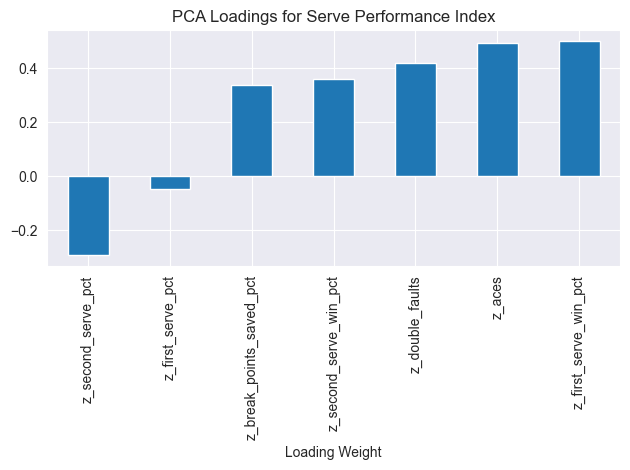

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Define which raw variables go into the serve performance index
performance_cols = [
    'aces',
    'double_faults',
    'first_serve_pct',
    'second_serve_pct',
    'break_points_saved_pct',
    'first_serve_win_pct',
    'second_serve_win_pct'
]

# Step 2: Create a new DataFrame with relevant columns and drop missing rows
metrics = player_df[['player_name', 'tourney_id', 'round_num', 'surface', 'year'] + performance_cols].copy()
metrics = metrics.dropna()

# Step 3: Z-score standardize the numerical performance metrics
scaler = StandardScaler()
scaled_array = scaler.fit_transform(metrics[performance_cols])

# Step 4: Assign back to a DataFrame with z_ column names
z_column_names = [f'z_{col}' for col in performance_cols]
scaled_df = pd.DataFrame(scaled_array, columns=z_column_names)

# Step 5: Add back identifiers (player, surface, round, etc.)
scaled_df_with_ids = pd.concat([metrics[['player_name', 'tourney_id', 'round_num', 'surface', 'year']].reset_index(drop=True), scaled_df], axis=1)

# Step 6: Run PCA on the scaled performance metrics
pca = PCA(n_components=1)
serve_index_scores = pca.fit_transform(scaled_df[z_column_names])

# Step 7: Save the PCA-based index and inspect weights
scaled_df_with_ids['serve_performance_index'] = serve_index_scores
weights = pd.Series(pca.components_[0], index=z_column_names)
print("PCA Weights (Loadings):")
print(weights.sort_values())

# Optional: visualize loading weights
weights.sort_values().plot(kind='bar', title='PCA Loadings for Serve Performance Index')
plt.xlabel('Loading Weight')
plt.tight_layout()
plt.show()

Results show that the serve performance index loads most strongly on first serve win %, aces, and double faults, suggesting that serve dominance is primarily driven by power, risk-taking, and success on first serves.

Interestingly, and quite surprising, double faults have a positive loading. While generally considered a negative aspect of a players game, this result reflects how aggressive serves also tend to double fault more. This does not imply double faults are beneficial, but that they co-occur with aggressive serve styles.

Conversely, first and second serve percentage have negative loadings, meaning players who land a higher proportion of serves-but perhaps play more conservatively-tend to have lower index values. This supports the interpretation that consistent serve styles are less defining of a dominant serve performance compared to an aggressive serve style.

The aforementioned Reilly Opelka is a great example to explain these results. At 6'11", he isn't the most coordinated or fast player compared to the pool of ATP players. He relies on heavily on a dominate serve performance because he knows getting into rallies will favor his opponents more. This is why you see players with similar characteristics-such as John Isner-invoke the serve-and-volley; cutting down the length of points dramatically to avoid getting into long rallies. In the trade-off between an aggressive second serve and a consistent one, players like Reilly Opelka will choose the former because they know their chances are winning a point through a long rally are generally much lower than that of their opponent.

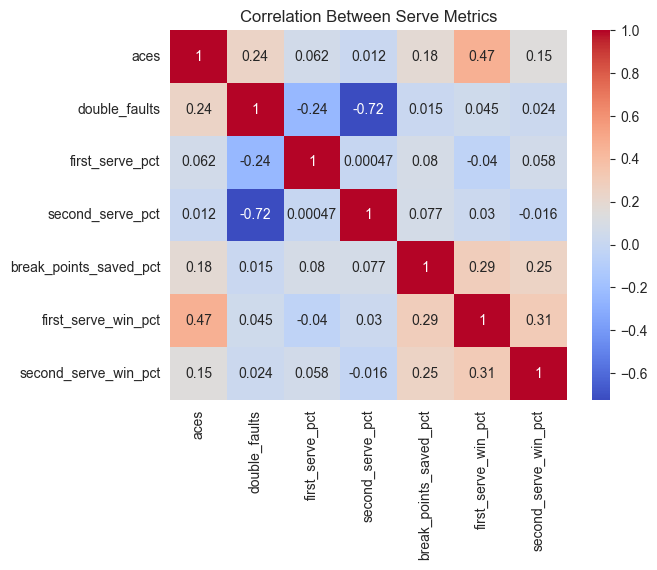

In [18]:
# heatmap to look at correlation across all metrics
corr_matrix = metrics[performance_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Serve Metrics')
plt.show()


Above is a matrix correlation heatmap looking at correlation across all serve metrics.

Regression on Serve Performance Index

In [19]:
# checking for proper columns
print(scaled_df_with_ids.columns)

# dropping NANs
fe_df = scaled_df_with_ids.dropna(subset = ['serve_performance_index', 'round_num', 'player_name', 'surface'])
# Sampling top 25 most active players
top_players = fe_df['player_name'].value_counts().head(25).index
fe_sample = fe_df[fe_df['player_name'].isin(top_players)].sample(1000, random_state = 1)

print(fe_sample.shape)
print(fe_sample['player_name'].nunique())

# surface conversion
fe_sample['surface'] = pd.Categorical(
    fe_sample['surface'], categories = ['Hard', 'Clay', 'Grass'],
    ordered = False)

# regression
import statsmodels.formula.api as smf
model_perf = smf.ols(
    formula = 'serve_performance_index ~ round_num + C(surface) + C(player_name)',
    data = fe_sample
).fit()

print(model_perf.summary())

Index(['player_name', 'tourney_id', 'round_num', 'surface', 'year', 'z_aces', 'z_double_faults', 'z_first_serve_pct', 'z_second_serve_pct', 'z_break_points_saved_pct', 'z_first_serve_win_pct',
       'z_second_serve_win_pct', 'serve_performance_index'],
      dtype='object')
(1000, 13)
25
                               OLS Regression Results                              
Dep. Variable:     serve_performance_index   R-squared:                       0.261
Model:                                 OLS   Adj. R-squared:                  0.241
Method:                      Least Squares   F-statistic:                     12.74
Date:                     Sun, 17 Aug 2025   Prob (F-statistic):           1.70e-47
Time:                             08:28:29   Log-Likelihood:                -1535.4
No. Observations:                     1000   AIC:                             3127.
Df Residuals:                          972   BIC:                             3264.
Df Model:                             

About 24% of the within-player variation in serve performance is explained by round progression and surface type. On average, serve performance drops by 0.0238 standard units with each tournament round. This makes sense because of possible fatigue, pressure, or better opponents. Compared to hard courts, serve performance is -0.49 standard units worse on Clay. Clay is a slower surface making easier to return and get breaks. Compared to Hard courts, serve performance is 0.43 standard units better on grass. Grass is a faster surface making it harder to return and easier to hit aces.


In [20]:
model_perf = smf.ols(
    formula = 'serve_performance_index ~ round_num * C(surface) + C(player_name)',
    data = fe_sample
).fit()

print(model_perf.summary())

                               OLS Regression Results                              
Dep. Variable:     serve_performance_index   R-squared:                       0.264
Model:                                 OLS   Adj. R-squared:                  0.242
Method:                      Least Squares   F-statistic:                     12.00
Date:                     Sun, 17 Aug 2025   Prob (F-statistic):           4.12e-47
Time:                             08:28:29   Log-Likelihood:                -1533.5
No. Observations:                     1000   AIC:                             3127.
Df Residuals:                          970   BIC:                             3274.
Df Model:                               29                                         
Covariance Type:                 nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

Changing the model to include a round number and surface interaction term slightly increased the Adj. R-squared value.